# About this Report

This report is based on Benchmark V4 and is sequel to `report.ipynb` based on Benchmark V3

## Changes in Benchmark V4

- Remove Constraint Weight from input variable because it seems to not correlate

- Decrease Gurobi Timeout 1000s -> 100s because it take too long to run benchmark

- Added multiple instance of D-Wave, now D-Wave has following instances:
    - Advantage_system4.1
    - Advantage_system6.4
    - Advantage2_prototype2.6

## Benchmark Result

In [10]:
# Import Object from result.json
import json

with open('result_v4.json') as f:
    data = json.load(f)

print(data[:1])

[{'nodes': 4, 'max_edge_weight': 9, 'avg_edge_weight': 4.6875, 'distance_matrix': [[0, 6, 7, 8], [6, 0, 7, 5], [7, 7, 0, 3], [8, 5, 3, 0]], 'interaction_matrix': [[0, 8, 8, 7], [8, 0, 2, 7], [8, 2, 0, 7], [7, 7, 7, 0]], 'qp_weight': 1000000, 'time_model_formulation': 0.006579875946044922, 'solvers_results': [{'name': 'Brute Force', 'objective': 222, 'execution_time': 1.9073486328125e-05, 'total_time': 1.9073486328125e-05}, {'name': 'Gurobi 10s', 'objective': 222.0, 'execution_time': 0.007771, 'total_time': 0.011676788330078125}, {'name': 'Gurobi 100s', 'objective': 222.0, 'execution_time': 0.006705, 'total_time': 0.007740974426269531}, {'name': 'Fixstars', 'objective': 222.0, 'execution_time': 0.038492, 'total_time': 2.651676893234253}, {'name': 'D-Wave AS4.1', 'objective': None, 'execution_time': None, 'total_time': None}, {'name': 'D-Wave AS6.4', 'objective': 222.0, 'execution_time': 0.094446, 'total_time': 2.5272367000579834}, {'name': 'D-Wave V2p2.6', 'objective': 222.0, 'execution

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

### Success Count by Solver vs $n$

Similar result with previous benchmark.

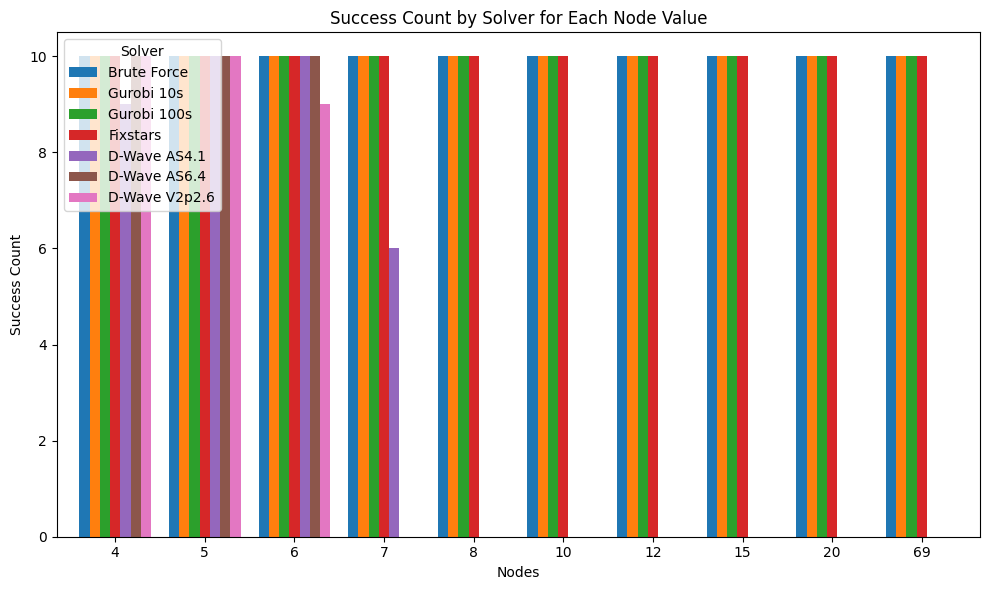

In [4]:
# Prepare data for plotting
records = []
for item in data:
    nodes = item["nodes"]
    for solver in item["solvers_results"]:
        success = solver["objective"] is not None and solver["execution_time"] is not None
        records.append({"nodes": nodes, "solver": solver["name"], "success": int(success)})

# Convert to DataFrame
df = pd.DataFrame(records)

# Group by nodes and solver to count successes
success_counts = df.groupby(["nodes", "solver"]).sum().reset_index()

# Pivot data for plotting
pivot_data = success_counts.pivot(index="nodes", columns="solver", values="success").fillna(0)

# Ensure legend order
solver_order = ["Brute Force", "Gurobi 10s", "Gurobi 100s", "Fixstars", "D-Wave AS4.1", "D-Wave AS6.4", "D-Wave V2p2.6"]
pivot_data = pivot_data[solver_order]

# Plot multi-bar chart
pivot_data.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title("Success Count by Solver for Each Node Value")
plt.xlabel("Nodes")
plt.ylabel("Success Count")
plt.legend(title="Solver", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Box and Whisker Plot of Execution Time vs Nodes

No difference from previous benchmark.

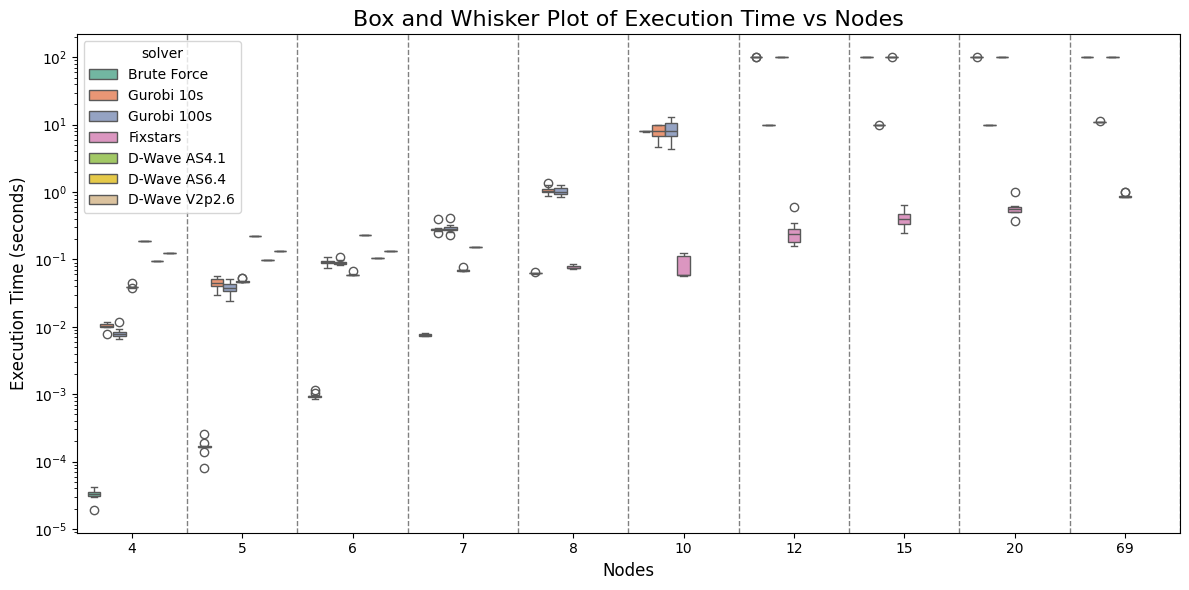

In [5]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    for result in dataset["solvers_results"]:
        plot_data.append({
            "nodes": dataset["nodes"],
            "solver": result["name"],
            "execution_time": result["execution_time"]
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for execution_time vs nodes
plt.figure(figsize=(12, 6))
sns.boxplot(x="nodes", y="execution_time", hue="solver", data=df_plot, palette="Set2")

# Add title and labels
plt.title('Box and Whisker Plot of Execution Time vs Nodes', fontsize=16)
plt.xlabel('Nodes', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)

# Add vertical lines as guidelines to separate each "nodes" group
nodes = df_plot['nodes'].unique()
for node in nodes:
    plt.axvline(x=list(nodes).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

plt.yscale("log")

# Show the plot
plt.tight_layout()
plt.show()

### Linear Plot of Execution Time for Fixstars and D-Wave

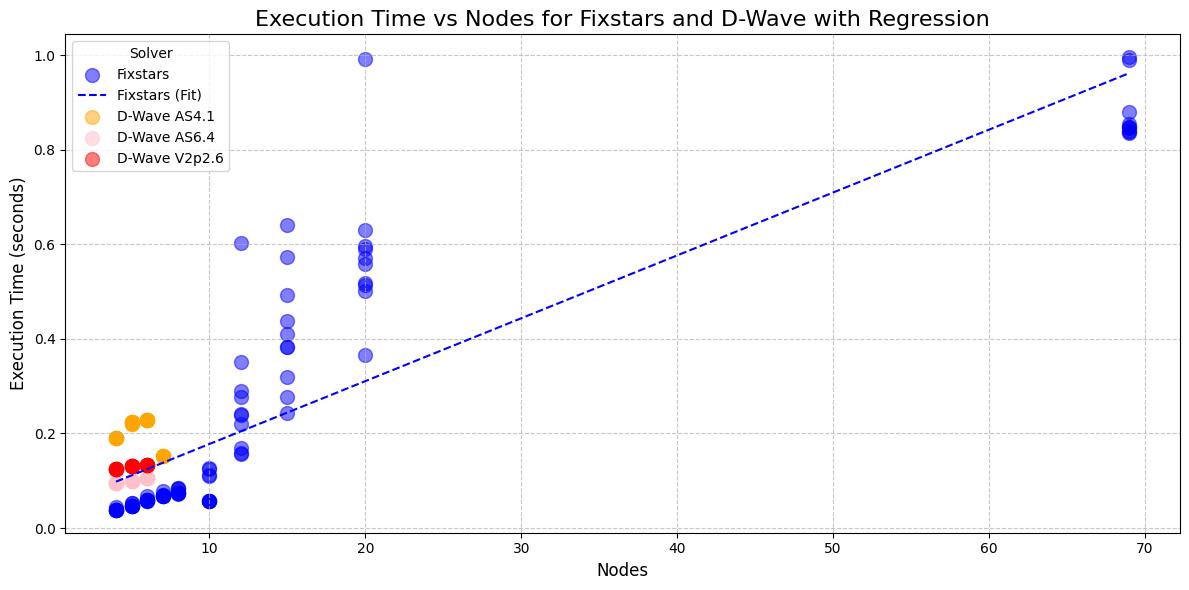

In [7]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    nodes = dataset["nodes"]
    for result in dataset["solvers_results"]:
        if result["execution_time"] is not None:  # Include only valid execution times
            plot_data.append({
                "nodes": nodes,
                "solver": result["name"],
                "execution_time": result["execution_time"]
            })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Filter data for Fixstars and D-Wave
fixstars_data = df_plot[df_plot["solver"] == "Fixstars"]
dwave41_data = df_plot[df_plot["solver"] == "D-Wave AS4.1"]
dwave64_data = df_plot[df_plot["solver"] == "D-Wave AS6.4"]
dwaveV2_data = df_plot[df_plot["solver"] == "D-Wave V2p2.6"]

# Function to perform linear regression and get line points
def add_regression_line(x, y, ax, label, color):
    # Reshape data for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y)
    
    # Predict y values for regression line
    x_line = np.linspace(min(x), max(x), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    
    # Plot the regression line
    ax.plot(x_line, y_line, label=f"{label} (Fit)", color=color, linestyle='--')

# Create scatter plot with regression lines
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot scatter for Fixstars with opacity
plt.scatter(fixstars_data["nodes"], fixstars_data["execution_time"], label="Fixstars", color="blue", s=100, alpha=0.5)
add_regression_line(fixstars_data["nodes"], fixstars_data["execution_time"], ax, "Fixstars", "blue")

# Plot scatter for D-Wave with opacity
plt.scatter(dwave41_data["nodes"], dwave41_data["execution_time"], label="D-Wave AS4.1", color="orange", s=100, alpha=0.5)
plt.scatter(dwave64_data["nodes"], dwave64_data["execution_time"], label="D-Wave AS6.4", color="pink", s=100, alpha=0.5)
plt.scatter(dwaveV2_data["nodes"], dwaveV2_data["execution_time"], label="D-Wave V2p2.6", color="red", s=100, alpha=0.5)

# Add labels, legend, and title
plt.title("Execution Time vs Nodes for Fixstars and D-Wave with Regression", fontsize=16)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Execution Time (seconds)", fontsize=12)
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### Box and Whisker Plot of Objective vs Nodes

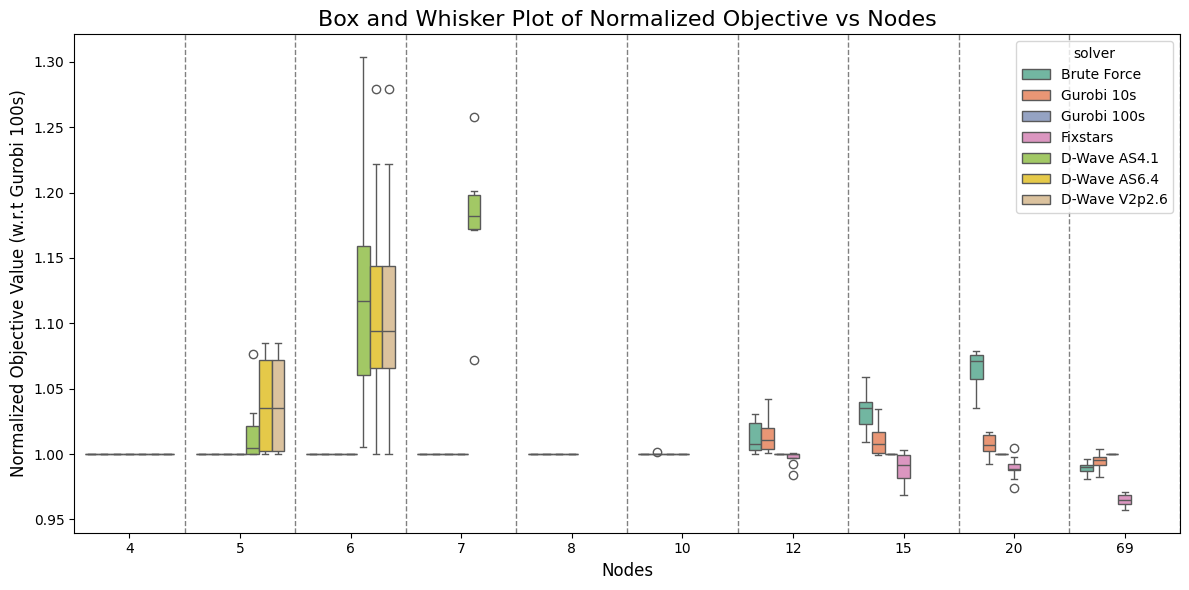

In [ ]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    # Extract objective value of Gurobi 1000s to normalize others
    gurobi_100s_objective = next(
        result["objective"] for result in dataset["solvers_results"] if result["name"] == "Gurobi 100s"
    )
    
    for result in dataset["solvers_results"]:
        # Skip failed solvers where objective is None
        if result["objective"] is None:
            continue
        
        # Normalize the objective value
        normalized_objective = result["objective"] / gurobi_100s_objective if gurobi_100s_objective != 0 else 0
        plot_data.append({
            "nodes": dataset["nodes"],
            "solver": result["name"],
            "normalized_objective": normalized_objective
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for normalized objective vs nodes
plt.figure(figsize=(12, 6))
sns.boxplot(x="nodes", y="normalized_objective", hue="solver", data=df_plot, palette="Set2", hue_order=["Brute Force", "Gurobi 10s", "Gurobi 100s", "Fixstars", "D-Wave AS4.1", "D-Wave AS6.4", "D-Wave V2p2.6"])

# Add title and labels
plt.title('Box and Whisker Plot of Normalized Objective vs Nodes', fontsize=16)
plt.xlabel('Nodes', fontsize=12)
plt.ylabel('Normalized Objective Value (w.r.t Gurobi 100s)', fontsize=12)

# Add vertical lines as guidelines to separate each "nodes" group
nodes = df_plot['nodes'].unique()
for node in nodes:
    plt.axvline(x=list(nodes).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()

# Summary

TODO